#### Torchify

In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
words = open('../names.txt', 'r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [60]:
vocab = sorted(set("".join(words)))
vocab = ['.'] + vocab
vocab_size = len(vocab)
vocab_size, vocab[:5]

(27, ['.', 'a', 'b', 'c', 'd'])

In [61]:
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for s,i in stoi.items()}
stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [62]:

# init dataset
block_size = 6

X,Y=[],[]
for w in words:
  context = [0] * block_size
  for ch in w+'.':
    X.append(context)
    Y.append(stoi[ch])
    context=context[1:] + [stoi[ch]]

X = torch.tensor(X)
Y = torch.tensor(Y)

print(X.shape, Y.shape)

torch.Size([228146, 6]) torch.Size([228146])


In [63]:
g = torch.Generator().manual_seed(821974)
class Linear:
  def __init__(self, fan_in, fan_out):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out)
  
  def __call__(self, x):
    self.out = x @ self.weight + self.bias
    return self.out
  
  def parameters(self):
    return [self.weight, self.bias]

# copypaste!!! cause me tired
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []




In [64]:
n_embd = 12
n_hidden = 100

layers = [
  Linear(block_size*n_embd, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden),          BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden),          BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden),          BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden),          BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),        BatchNorm1d(vocab_size)
]

C  = torch.randn((vocab_size, n_embd)          , generator=g)
parameters = [C] + [p for l in layers for p in l.parameters()]
for p in parameters:
  p.requires_grad = True


In [65]:
lr = 0.1
steps = 100_000
decay_steps = 10_000
decay_factor = 10
batch_size = 64 

lossi = []

for i in range(steps+decay_steps):
  # forward pass
  batch = torch.randint(0, X.shape[0], (batch_size, ), generator=g)
  emb = C[X[batch]]
  x = emb.view(-1, block_size*n_embd)

  for l in layers:
    x = l(x)
  loss = F.cross_entropy(x, Y[batch])
  lossi.append(loss.item())

  # reset grads
  for p in parameters:
    p.grad = None
  # recompute
  loss.backward()
  # update
  lri = lr if i < steps else lr/decay_factor
  for p in parameters:
    p.data += -lri * p.grad

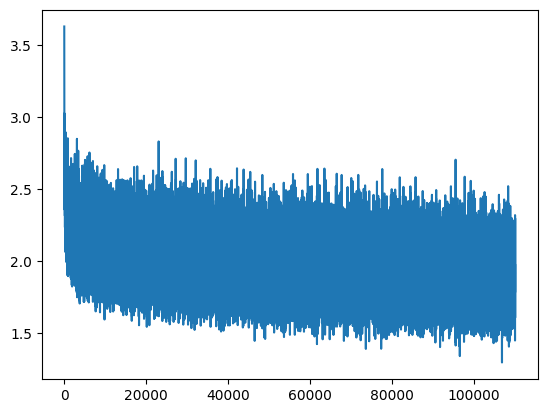

In [66]:
plt.plot(lossi)

In [67]:
# inference
# put layers into eval mode
for layer in layers:
  layer.training = False

for _ in range(20):
  context = [0] * block_size
  out=[]
  while True:
    emb = C[context]
    x = emb.view(-1, block_size*n_embd)
    for l in layers:
      x = l(x)
    probs = F.softmax(x, dim=1)
    hit = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(hit)
    if hit == 0:
      break
    context=context[1:]+[hit]
  print(''.join(itos[o] for o in out))

arthan.
sasi.
ellajareto.
acessa.
brelin.
isuphi.
hixal.
izathun.
gyanlee.
nahlani.
aden.
yailah.
hembrose.
asfrey.
aryan.
antwikoa.
deilen.
jumae.
barryn.
manvice.
